In [1]:
# Importing all needed libraries
import os

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd # Data manipulation lib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Conv1D, MaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, ConfusionMatrixDisplay

import xgboost as xgb
from xgboost import XGBClassifier

## Data loading and preprocessing




In [ ]:
# Creating files list to create the dataframes
files = sorted(os.listdir('attacked_messages'))
train_files = files[4:]
test_files = files[:4]

def read(file_path: str):
    """ Method that read a csv file and return a pandas dataframe """
    return pd.read_csv(file_path, index_col=0)

#Read data
train_data = pd.concat(map(read, [os.path.join('attacked_messages', f) for f in files[4:]]))
test_data = pd.concat(map(read, [os.path.join('attacked_messages', f) for f in files[:4]]))

print(train_data.head())
print(test_data.head())

Then, we use MinMaxScaler from Scikit to scale the necessary values between 0 and 1 to ease the differents networks training.

In [ ]:
# Defining scaler
scaler = MinMaxScaler()
# Fit the scaler on the train_data
scaler.fit(train_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']])
# Transform the data
train_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']] = scaler.transform(train_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']])
# Fit the scaler on the test_data
scaler.fit(test_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']])
# Transform the data
test_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']] = scaler.transform(test_data[['ALT', 'LAT-POS', 'LON-POS', 'SPEED', 'T-H']])

print(train_data.head())
print(test_data.head())

      y       ALT   LAT-POS   LON-POS     SPEED       T-H
time                                                     
0     0  0.083675  0.994722  0.718627  0.264493  0.573704
1     0  0.084299  0.994716  0.718600  0.264493  0.573704
2     0  0.084299  0.994710  0.718573  0.264493  0.573704
3     0  0.084299  0.994710  0.718573  0.260870  0.586991
4     0  0.084924  0.994706  0.718548  0.260870  0.586991
      y      ALT   LAT-POS   LON-POS     SPEED       T-H
time                                                    
0     0  0.92008  0.999953  0.636439  0.955556  0.391406
1     0  0.92008  0.999953  0.636439  0.955556  0.391406
2     0  0.92008  0.999953  0.636439  0.955556  0.391406
3     0  0.92008  0.999953  0.636439  0.955556  0.391406
4     0  0.92008  0.999921  0.636438  0.955556  0.391406


And finally, we create the training and testing sets for model training :

In [ ]:
x_train = np.array(train_data.drop('y', 1))
y_train = np.array(train_data['y'])
x_test = np.array(test_data.drop('y', 1))
y_test = np.array(test_data['y'])

print("Training values sample:\n")
print(x_train[0:5])
print(y_train[0:5])
print("\nTesting values sample:\n")
print(x_test[0:5])
print(y_test[0:5])

Training values sample:

[[0.08367469 0.99472225 0.71862687 0.26449275 0.57370396]
 [0.08429913 0.99471639 0.71860018 0.26449275 0.57370396]
 [0.08429913 0.99471032 0.7185735  0.26449275 0.57370396]
 [0.08429913 0.99471032 0.7185735  0.26086957 0.58699097]
 [0.08492357 0.99470551 0.71854776 0.26086957 0.58699097]]
[0 0 0 0 0]

Testing values sample:

[[0.92007997 0.99995315 0.63643941 0.95555556 0.39140635]
 [0.92007997 0.99995315 0.63643941 0.95555556 0.39140635]
 [0.92007997 0.99995315 0.63643941 0.95555556 0.39140635]
 [0.92007997 0.99995315 0.63643941 0.95555556 0.39140635]
 [0.92007997 0.99992073 0.63643845 0.95555556 0.39140635]]
[0 0 0 0 0]


/tmp/ipykernel_64009/3638399746.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = np.array(train_data.drop('y', 1))
/tmp/ipykernel_64009/3638399746.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = np.array(test_data.drop('y', 1))


## Models Testing



In [ ]:
# Define usefull variables for models training
batch_sizes = [1, 32, 128,  512] # Differents batch sizes between 1 and 512
losses = ['mse', 'binary_crossentropy']

# Define a list containing all tree number for XGBoost training 
trees_nb = [1, 50, 100, 500, 1000, 1250]

# Defining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### Defining models

#### Model 1: LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, 5), return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation="sigmoid"))

2022-01-08 11:05:58.655437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 11:05:59.242759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-08 11:05:59.242821: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-08 11:05:59.244555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

#### Model 2: 1D CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(8, 1, activation='relu'))
cnn_model.add(Conv1D(16, 1, activation='relu'))
cnn_model.add(Conv1D(32, 1, activation='relu'))
cnn_model.add(Conv1D(64, 1, activation='relu'))
cnn_model.add(Conv1D(128, 1, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dense(125))
cnn_model.add(Dense(1, activation='sigmoid'))

## Training models

In [ ]:
lstm_histories = []
lstm_prediction = []
for b in batch_sizes:
    for l in losses:
        lstm_model.compile(loss=l, optimizer='adam', metrics=['accuracy'])
        lstm_histories.append(
            lstm_model.fit(
                x_train.reshape(x_train.shape[0], 1, 5), 
                y_train.reshape(y_train.shape[0], 1, 1), 
                batch_size=b, 
                epochs=5, 
                verbose=1, 
                validation_data=(
                    x_test.reshape(x_test.shape[0], 1, 5), 
                    y_test.reshape(y_test.shape[0], 1, 1)
                ), 
                callbacks=[early_stopping]
            )
        )
        lstm_prediction.append(lstm_model.predict(x_test.reshape(x_test.shape[0], 1, 5)))
        print("\n")

Epoch 1/5
66172/66172 [==============================] - 179s 3ms/step - loss: 0.0332 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 2/5
66172/66172 [==============================] - 173s 3ms/step - loss: 0.0330 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 3/5
66172/66172 [==============================] - 208s 3ms/step - loss: 0.0330 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 4/5
66172/66172 [==============================] - 229s 3ms/step - loss: 0.0330 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 5/5
66172/66172 [==============================] - 197s 3ms/step - loss: 0.0330 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670


Epoch 1/5
66172/66172 [==============================] - 141s 2ms/step - loss: 0.1494 - accuracy: 0.9659 - val_loss: 0.1475 - val_accuracy: 0.9670
Epoch 2/5
66172/66172 [==============================] - 139s 2ms/step - loss: 0.1495 - accuracy: 0.9659 - val_loss:

In [ ]:
cnn_histories = []
cnn_prediction = []
for b in batch_sizes:
    for l in losses:
        cnn_model.compile(loss=l, optimizer='adam', metrics=['accuracy'])
        cnn_histories.append(
            cnn_model.fit(
                x_train.reshape(x_train.shape[0], x_train.shape[1], 1), 
                y_train.reshape(y_train.shape[0], 1), 
                batch_size=b, 
                epochs=5, 
                verbose=1, 
                validation_data=(
                    x_test.reshape(x_test.shape[0], x_test.shape[1], 1), 
                    y_test.reshape(y_test.shape[0], 1)
                ), 
                callbacks=[early_stopping]
            )
        )
        cnn_prediction.append(cnn_model.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], 1)))
        print("\n")

Epoch 1/5
66172/66172 [==============================] - 116s 2ms/step - loss: 0.0331 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 2/5
66172/66172 [==============================] - 110s 2ms/step - loss: 0.0330 - accuracy: 0.9659 - val_loss: 0.0319 - val_accuracy: 0.9670
Epoch 3/5
66172/66172 [==============================] - 106s 2ms/step - loss: 0.0331 - accuracy: 0.9659 - val_loss: 0.0321 - val_accuracy: 0.9670
Epoch 4/5
66172/66172 [==============================] - 109s 2ms/step - loss: 0.0331 - accuracy: 0.9659 - val_loss: 0.0320 - val_accuracy: 0.9670
Epoch 5/5
66172/66172 [==============================] - 111s 2ms/step - loss: 0.0331 - accuracy: 0.9659 - val_loss: 0.0320 - val_accuracy: 0.9670


Epoch 1/5
66172/66172 [==============================] - 106s 2ms/step - loss: 0.1507 - accuracy: 0.9659 - val_loss: 0.1450 - val_accuracy: 0.9670
Epoch 2/5
66172/66172 [==============================] - 120s 2ms/step - loss: 0.1506 - accuracy: 0.9659 - val_loss:

In [ ]:
xgboost_histories = []
xgboost_prediction = []
eval_set = [(x_train, y_train), (x_test, y_test)]
for n in trees_nb:
    model = XGBClassifier(max_depth=20, learning_rate=0.2, n_estimators=n, verbosity=1)
    xgboost_histories.append(model.fit(x_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set))
    xgboost_prediction.append(model.predict(x_test))
    print("\n")

## Results analysis



In [ ]:
def display_curves(histories: list, losses: list[str], batch_sizes: list[int], model_name: str):
    """ Display 4 curves from the given history list(accuracy, loss, val_loss, val_accuracy) """
    for k in range(len(losses)):
        loss_history = [histories[i] for i in range(k, len(histories), len(losses))]
        fig, axs = plt.subplots(len(loss_history), 2, figsize=(15,15))
        fig.suptitle('Training and validation metrics of ' + model_name + " model, " + losses[k])
        for i in range(len(loss_history)):
            axs[i, 0].title.set_text("Batch size of " + str(batch_sizes[i]))
            axs[i, 0].plot(loss_history[i].epoch, loss_history[i].history['loss'], 'g', label='Training loss')
            axs[i, 0].plot(loss_history[i].epoch, loss_history[i].history['val_loss'], 'r', label='Validation loss')
            axs[i, 1].plot(loss_history[i].epoch, loss_history[i].history['accuracy'], 'g', label='Training accuracy')
            axs[i, 1].plot(loss_history[i].epoch, loss_history[i].history['val_accuracy'], 'r', label='Validation accuracy')
            axs[i, 0].legend(loc='upper right')
            axs[i, 1].legend(loc='lower right')

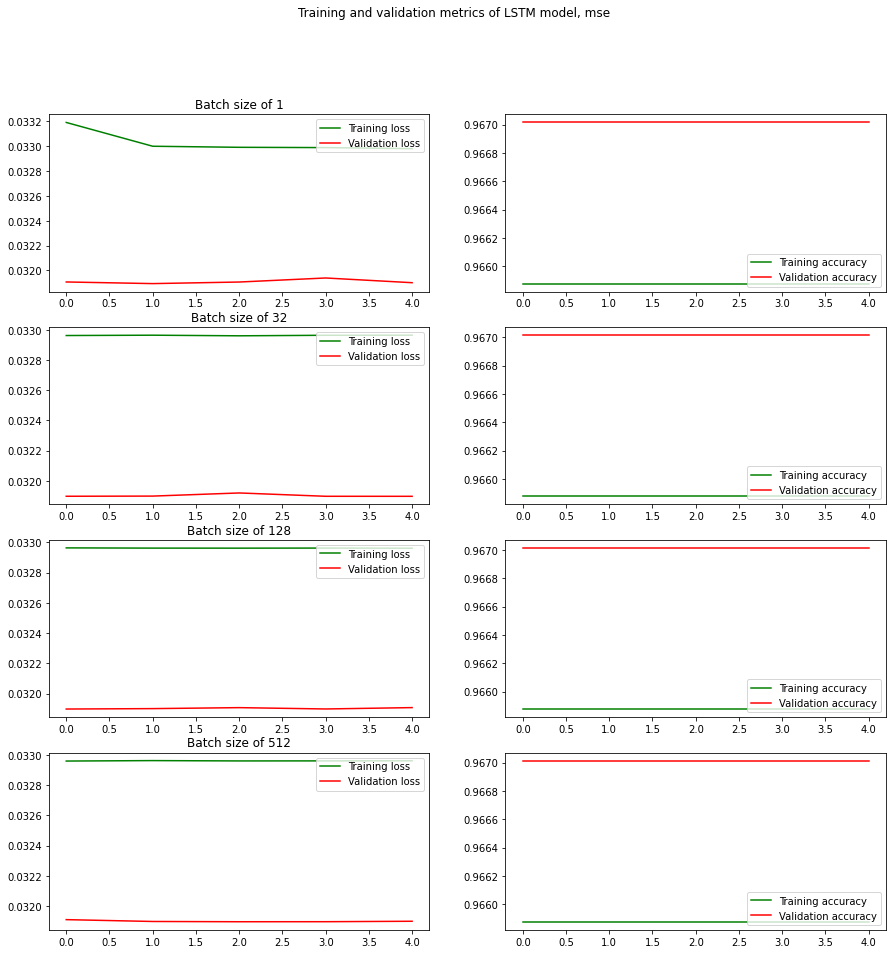

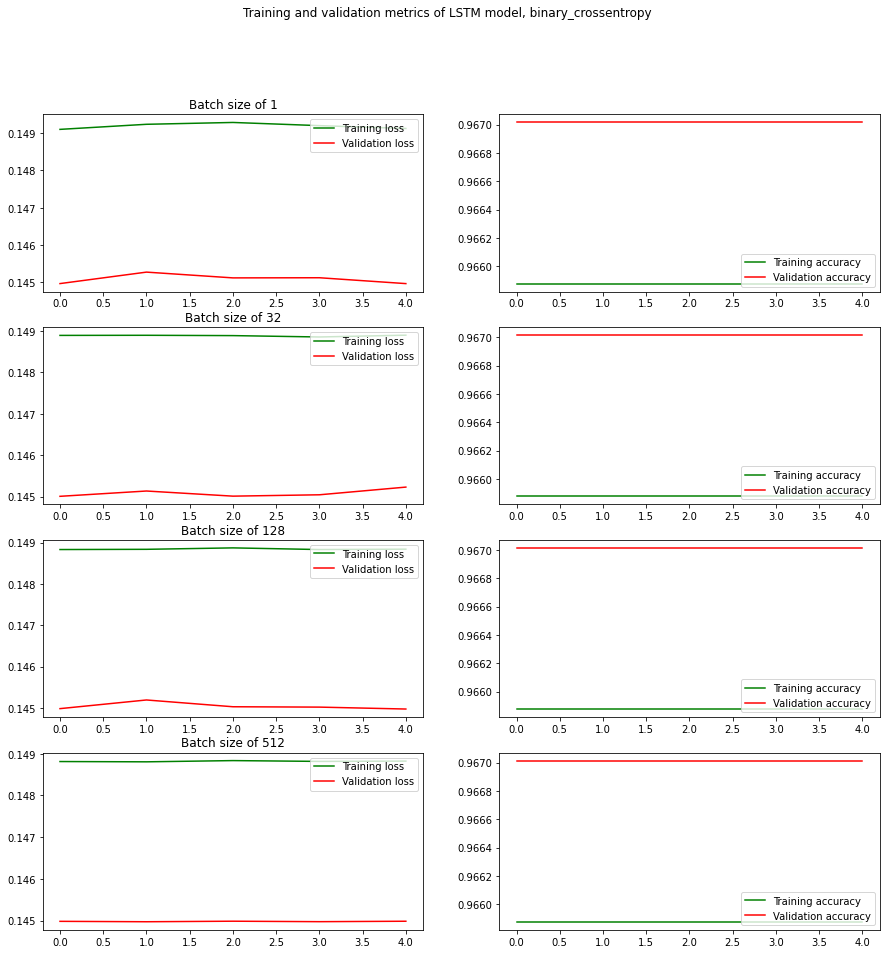

In [ ]:
# Displaying lstm model curves
display_curves(lstm_histories, losses, batch_sizes, "LSTM")

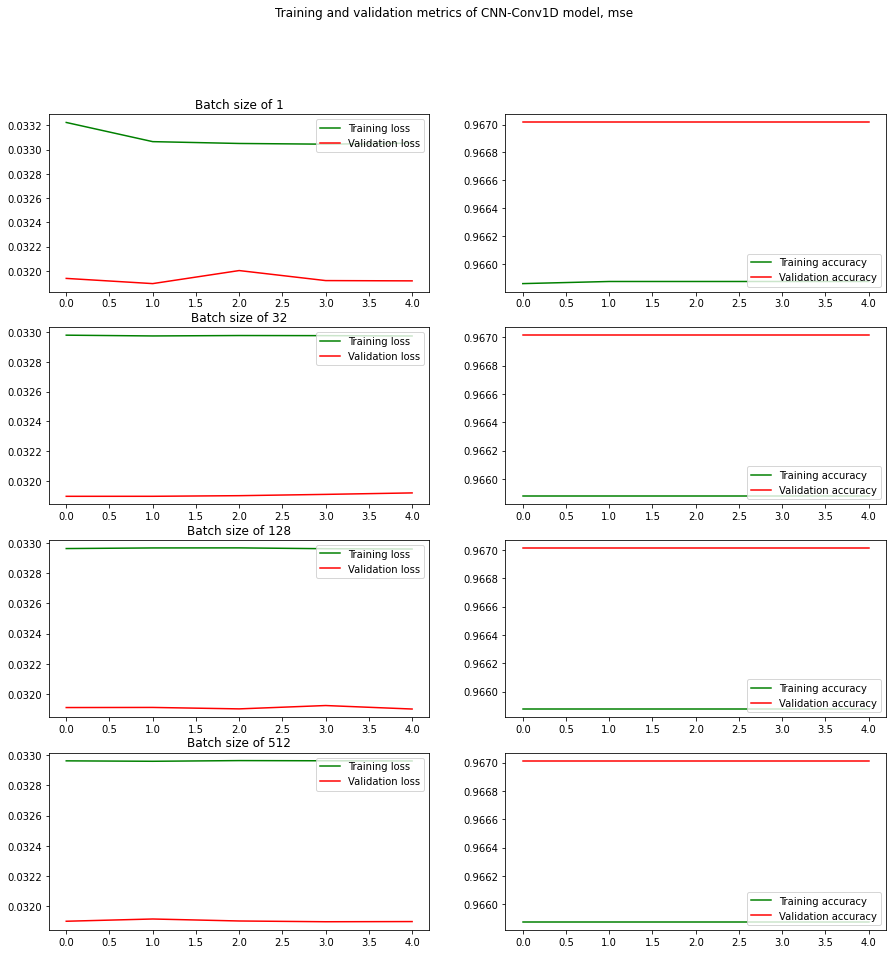

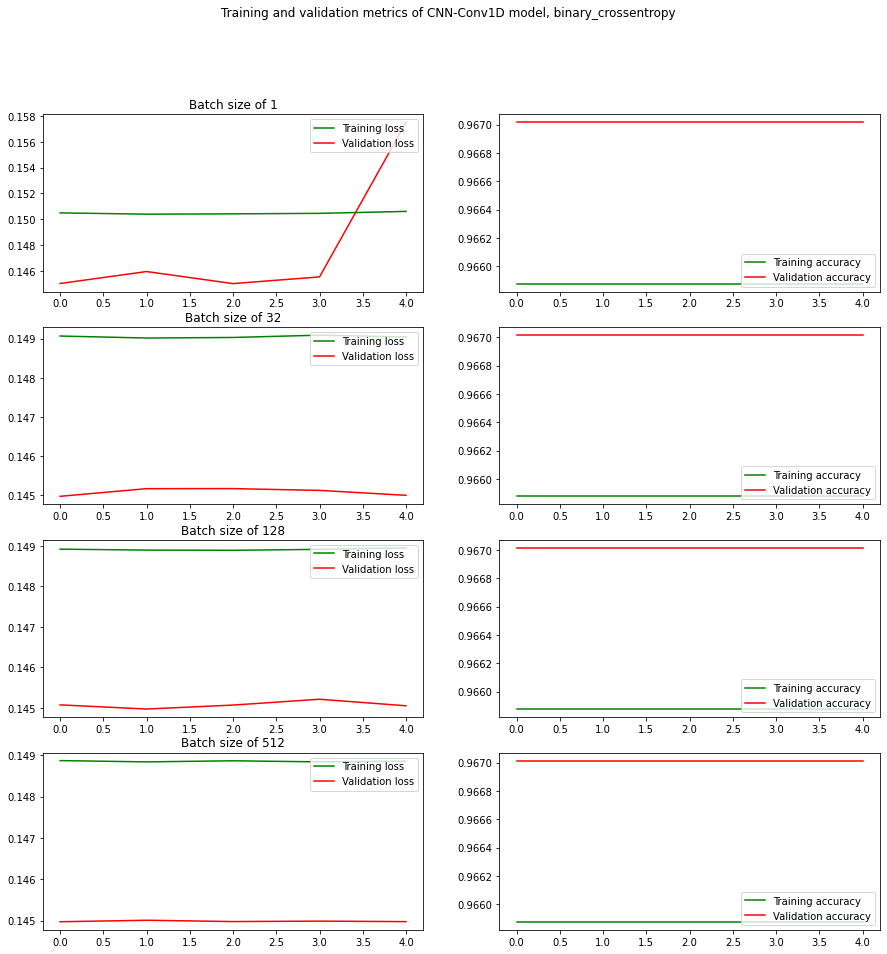

In [ ]:
# Displaying cnn model curves
display_curves(cnn_histories, losses, batch_sizes, "CNN-Conv1D")

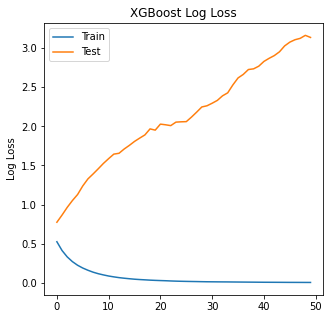

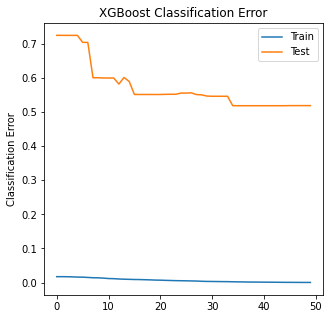

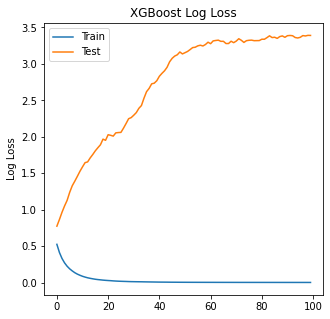

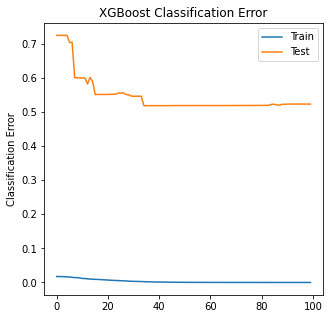

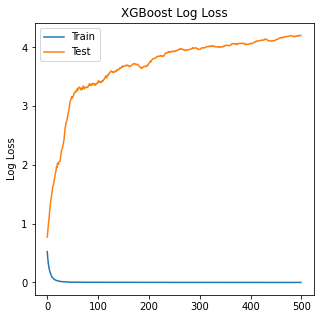

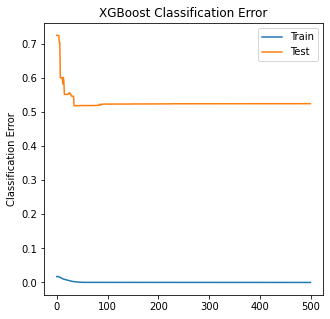

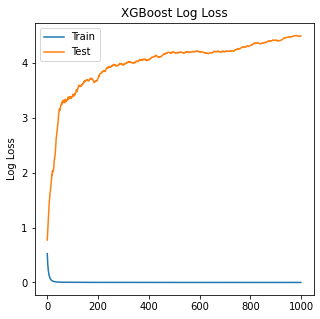

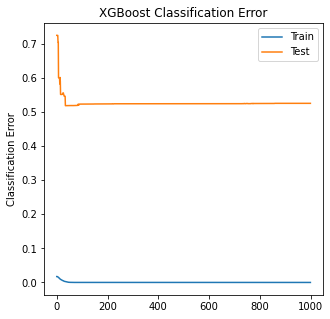

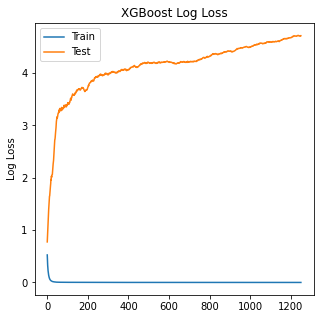

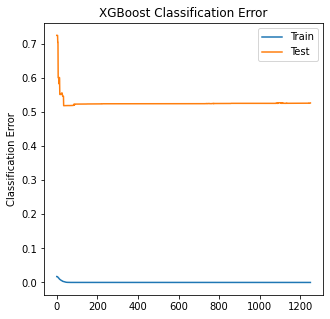

In [ ]:
# Retrieve performance metrics of the xgboost classifier
for x in xgboost_histories[1:]:
    results = x.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
     # Plotting log loss
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    
    
    # plot classification error
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

In [ ]:
def display_accuracy(y_pred, y_test):
    """ Method that display the accuracy of a set of prediction"""
    for p in y_pred:
        accuracy = accuracy_score(y_test, [np.round(value) for value in p])
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        
def plot_cm(y_pred, y_test):
    """ Method that plot the confusion matrixes of a set of prediction """
    for p in y_pred:
        cm = confusion_matrix(y_test, [np.round(value) for value in p])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

In [ ]:
# Arranging cnn prediction to ease accuracy computation
cnn_prediction = np.array(cnn_prediction)
arranged_cnn_prediction = []
for pred in cnn_prediction:
    arranged_cnn_prediction.append([p[0] for p in pred])

In [ ]:
print("LSTM diffents accuracies: ")
display_accuracy(lstm_prediction, y_test)
print("CNN-Conv1D diffents accuracies: ")
display_accuracy(arranged_cnn_prediction, y_test)
print("XGBoost diffents accuracies: ")
display_accuracy(xgboost_prediction, y_test)

LSTM diffents accuracies: 
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
CNN-Conv1D diffents accuracies: 
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
Accuracy: 96.70%
XGBoost diffents accuracies: 
Accuracy: 27.49%
Accuracy: 48.10%
Accuracy: 47.66%
Accuracy: 47.54%
Accuracy: 47.44%
Accuracy: 47.32%


Confusion Matrix:


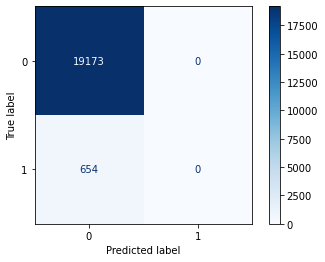

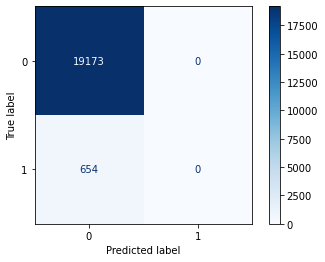

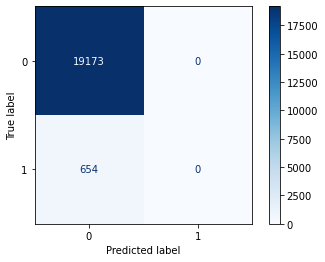

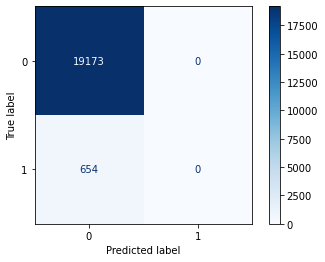

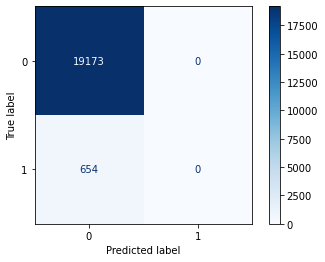

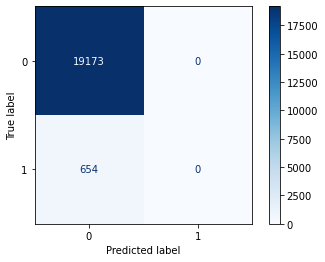

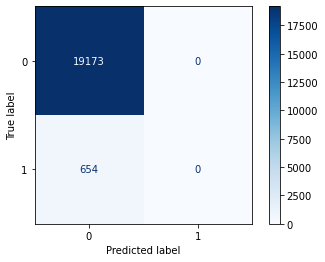

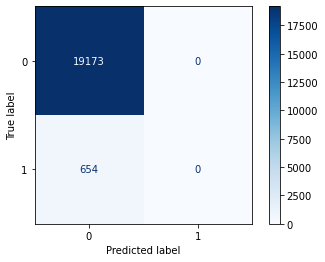

In [ ]:
# LSTM Model Confusion matrixes
plot_cm(lstm_prediction, y_test)

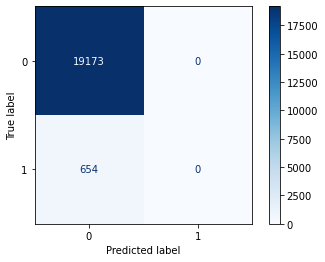

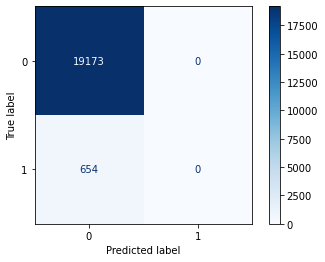

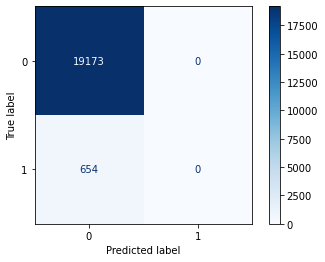

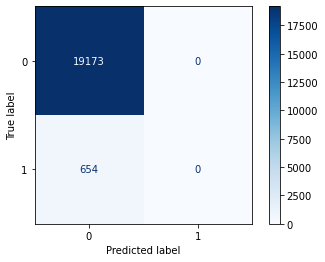

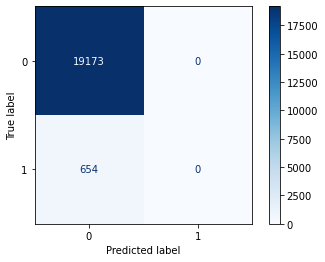

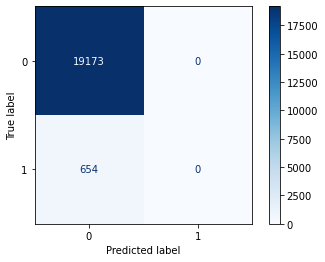

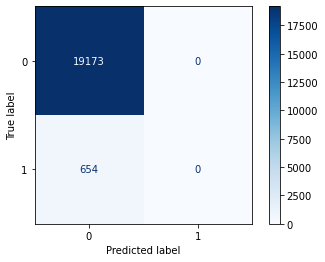

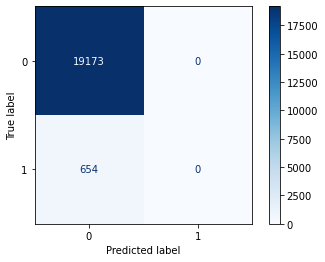

In [ ]:
# CNN Model Confusion matrixes
plot_cm(arranged_cnn_prediction, y_test)

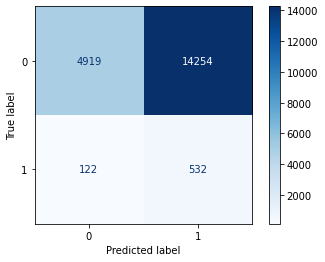

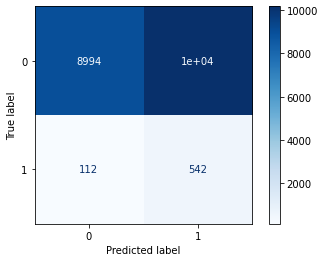

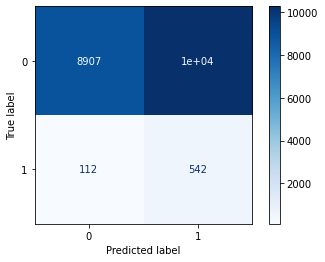

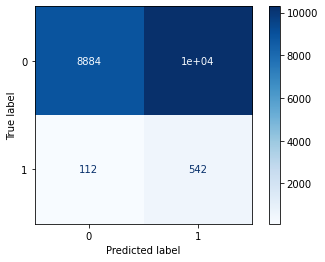

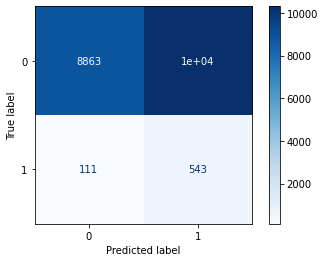

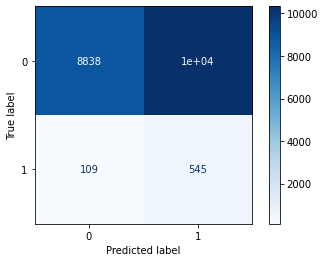

In [ ]:
# XGBoost Model Confusion matrixes
plot_cm(xgboost_prediction, y_test)